# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#)

### Import the necessary libraries

In [3]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

C:\Users\Balajisri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Balajisri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Balajisri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Balajisri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: Futu

### Change directory

In [4]:
#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lab_Res9_Internal/')

### Load the training data from train.csv file

In [5]:
# SETTINGS

#DATASET_FOLDER = "/content/drive/My Drive/Colab Notebooks/Lab_Res9_Internal/"
TRAIN_CSV = "train_labels.csv"
#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

#images_zip_path = DATASET_FOLDER + "images.zip"

### Print the shape of the train dataset

In [6]:
import pandas as pd

In [7]:
train_df = pd.read_csv(TRAIN_CSV)


In [8]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [10]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
      if (col !=0):
        index=0
        row_values=[]
             
        for i, r in enumerate(row[0:8]): # Parse row with seven entities
            if (i!=0 and i!=3):
               row_values.append(int(r))
            elif(i==0):
               paths.append(r)

            
              
        image_height, image_width, x0, y0, x1, y1 = row_values 
       # path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        coords[col-1, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col-1, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col-1, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col-1, 3] = (y1 - y0) * IMAGE_SIZE / image_height
     



### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [11]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#paths1 = paths
for i, f in enumerate(paths):
    img = Image.open('images_racoon/images/images/'+f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [12]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [13]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [14]:
gt = coords


### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [15]:

EPOCHS = 30 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.


In [16]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

Epoch 1/30
173/173 [==============================] - 6s 37ms/step - loss: 3559.2056 - IoU: 0.0642
Epoch 2/30
173/173 [==============================] - 0s 1ms/step - loss: 1114.6984 - IoU: 0.3477
Epoch 3/30
173/173 [==============================] - 0s 1ms/step - loss: 910.3538 - IoU: 0.4044
Epoch 4/30
173/173 [==============================] - 0s 1ms/step - loss: 914.7932 - IoU: 0.4474
Epoch 5/30
173/173 [==============================] - 0s 1ms/step - loss: 632.0216 - IoU: 0.5105
Epoch 6/30
173/173 [==============================] - 0s 1ms/step - loss: 510.9840 - IoU: 0.5107
Epoch 7/30
173/173 [==============================] - 0s 1ms/step - loss: 443.8444 - IoU: 0.5470
Epoch 8/30
173/173 [==============================] - 0s 1ms/step - loss: 382.1174 - IoU: 0.5693
Epoch 9/30
173/173 [==============================] - 0s 1ms/step - loss: 318.6335 - IoU: 0.6157
Epoch 10/30
173/173 [==============================] - 0s 1ms/step - loss: 290.5763 - IoU: 0.6268
Epoch 11/30
173/173 [=====

### Pick a test image from the given data

In [17]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
!apt-get -qq install -y libsm6 libxext6
!pip install -q -U opencv-python



'apt-get' is not recognized as an internal or external command,
operable program or batch file.
You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:

#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lab_Res9_Internal/images_racoon/images')


In [19]:

import cv2
filename = "images_racoon/images/raccoon-18.jpg"
unscaled = cv2.imread(filename) # Original image for display
# show the image
#cv2.imshow("Image", unscaled)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [20]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [21]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

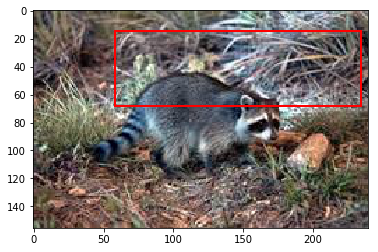

In [22]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

In [23]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

In [24]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Change your present working directory

In [25]:
#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lab_Res9_Internal')

### Load your data file

In [26]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())


            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


#### Plot data

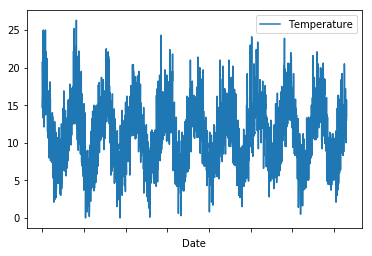

In [27]:
df.plot()

#### Descibe your dataframe

In [28]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [29]:
# Null Values?
df.isnull().sum()
print(df.isnull().any(axis=1).sum())

0


#### Drop null values

In [30]:
df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9FE0197B8>]],
      dtype=object)

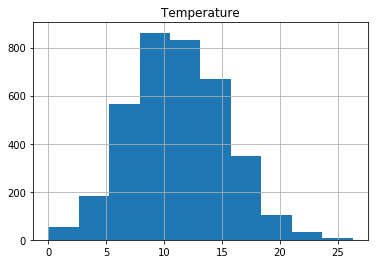

In [31]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [32]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [33]:
dataset = df.astype('float32')

#### Check the maximum and minimum values of scaled data

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [35]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [36]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [37]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [38]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [39]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [40]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

171
X 171 to 172
[0.16730039]
Y 172
0.2699619813915291
172
X 172 to 173
[0.26996198]
Y 173
0.18250951825013595
173
X 173 to 174
[0.18250952]
Y 174
0.2205323330413567
174
X 174 to 175
[0.22053233]
Y 175
0.23574144445329223
175
X 175 to 176
[0.23574144]
Y 176
0.2775665552281878
176
X 176 to 177
[0.27756656]
Y 177
0.34980988882695446
177
X 177 to 178
[0.34980989]
Y 178
0.3878327036181752
178
X 178 to 179
[0.3878327]
Y 179
0.3612167405165971
179
X 179 to 180
[0.36121674]
Y 180
0.3612167405165971
180
X 180 to 181
[0.36121674]
Y 181
0.4068441110137856
181
X 181 to 182
[0.40684411]
Y 182
0.38022814791220744
182
X 182 to 183
[0.38022815]
Y 183
0.24714829614293482
183
X 183 to 184
[0.2471483]
Y 184
0.26615970353854523
184
X 184 to 185
[0.2661597]
Y 185
0.2813688330811717
185
X 185 to 186
[0.28136883]
Y 186
0.30798481431344077
186
X 186 to 187
[0.30798481]
Y 187
0.2509505739959187
187
X 187 to 188
[0.25095057]
Y 188
0.31558937001940857
188
X 188 to 189
[0.31558937]
Y 189
0.33840303713731185
189


X 379 to 380
[0.5361217]
Y 380
0.6007604809535642
380
X 380 to 381
[0.60076048]
Y 381
0.9125475549892978
381
X 381 to 382
[0.91254755]
Y 382
0.6844106662419733
382
X 382 to 383
[0.68441067]
Y 383
0.7490494803961542
383
X 383 to 384
[0.74904948]
Y 384
0.9581749617478683
384
X 384 to 385
[0.95817496]
Y 385
0.7794677032200252
385
X 385 to 386
[0.7794677]
Y 386
0.7338402964614549
386
X 386 to 387
[0.7338403]
Y 387
0.6007604809535642
387
X 387 to 388
[0.60076048]
Y 388
0.6463878514507526
388
X 388 to 389
[0.64638785]
Y 389
0.6996197776539089
389
X 389 to 390
[0.69961978]
Y 390
0.5057034439755123
390
X 390 to 391
[0.50570344]
Y 391
0.5551331104563756
391
X 391 to 392
[0.55513311]
Y 392
0.4752851848902593
392
X 392 to 393
[0.47528518]
Y 393
0.6463878514507526
393
X 393 to 394
[0.64638785]
Y 394
0.6501901474344275
394
X 394 to 395
[0.65019015]
Y 395
0.5323194070770905
395
X 395 to 396
[0.53231941]
Y 396
0.5551331104563756
396
X 396 to 397
[0.55513311]
Y 397
0.5057034439755123
397
X 397 to 398


Y 626
0.21673003705768185
626
X 626 to 627
[0.21673004]
Y 627
0.15969581487085074
627
X 627 to 628
[0.15969581]
Y 628
0.15209125916488297
628
X 628 to 629
[0.15209126]
Y 629
0.20152092564574633
629
X 629 to 630
[0.20152093]
Y 630
0.23954374043696708
630
X 630 to 631
[0.23954374]
Y 631
0.3231939257253763
631
X 631 to 632
[0.32319393]
Y 632
0.43726237009903857
632
X 632 to 633
[0.43726237]
Y 633
0.29277566664012333
633
X 633 to 634
[0.29277567]
Y 634
0.34980988882695446
634
X 634 to 635
[0.34980989]
Y 635
0.2965779626237982
635
X 635 to 636
[0.29657796]
Y 636
0.23954374043696708
636
X 636 to 637
[0.23954374]
Y 637
0.23954374043696708
637
X 637 to 638
[0.23954374]
Y 638
0.3269962217090512
638
X 638 to 639
[0.32699622]
Y 639
0.23193916660030833
639
X 639 to 640
[0.23193917]
Y 640
0.5019011479918374
640
X 640 to 641
[0.50190115]
Y 641
0.3764258519285326
641
X 641 to 642
[0.37642585]
Y 642
0.1787072222664611
642
X 642 to 643
[0.17870722]
Y 643
0.2205323330413567
643
X 643 to 644
[0.22053233]

X 781 to 782
[0.59695818]
Y 782
0.7490494803961542
782
X 782 to 783
[0.74904948]
Y 783
0.6615969628626882
783
X 783 to 784
[0.66159696]
Y 784
0.547528518489026
784
X 784 to 785
[0.54752852]
Y 785
0.6425855554670779
785
X 785 to 786
[0.64258556]
Y 786
0.7262357770168689
786
X 786 to 787
[0.72623578]
Y 787
0.7756654072363504
787
X 787 to 788
[0.77566541]
Y 788
0.7642585918080897
788
X 788 to 789
[0.76425859]
Y 789
0.75665399984074
789
X 789 to 790
[0.756654]
Y 790
0.8365019254068564
790
X 790 to 791
[0.83650193]
Y 791
0.7794677032200252
791
X 791 to 792
[0.7794677]
Y 792
0.8403042213905312
792
X 792 to 793
[0.84030422]
Y 793
0.7832699992037001
793
X 793 to 794
[0.78327]
Y 794
0.5703422218683112
794
X 794 to 795
[0.57034222]
Y 795
0.7832699992037001
795
X 795 to 796
[0.78327]
Y 796
0.817490518011246
796
X 796 to 797
[0.81749052]
Y 797
0.6159696286268815
797
X 797 to 798
[0.61596963]
Y 798
0.5361217030607652
798
X 798 to 799
[0.5361217]
Y 799
0.5513308144727008
799
X 799 to 800
[0.55133081

Y 999
0.395437259324143
999
X 999 to 1000
[0.39543726]
Y 1000
0.5855513332802467
1000
X 1000 to 1001
[0.58555133]
Y 1001
0.40304185129149267
1001
X 1001 to 1002
[0.40304185]
Y 1002
0.3650190365002719
1002
X 1002 to 1003
[0.36501904]
Y 1003
0.3536121848106293
1003
X 1003 to 1004
[0.35361218]
Y 1004
0.5285171110934156
1004
X 1004 to 1005
[0.52851711]
Y 1005
0.29277566664012333
1005
X 1005 to 1006
[0.29277567]
Y 1006
0.3612167405165971
1006
X 1006 to 1007
[0.36121674]
Y 1007
0.28897338878713946
1007
X 1007 to 1008
[0.28897339]
Y 1008
0.2623574256855613
1008
X 1008 to 1009
[0.26235743]
Y 1009
0.25855514783257744
1009
X 1009 to 1010
[0.25855515]
Y 1010
0.2205323330413567
1010
X 1010 to 1011
[0.22053233]
Y 1011
0.22813688874732446
1011
X 1011 to 1012
[0.22813689]
Y 1012
0.31558937001940857
1012
X 1012 to 1013
[0.31558937]
Y 1013
0.34600762910466154
1013
X 1013 to 1014
[0.34600763]
Y 1014
0.4752851848902593
1014
X 1014 to 1015
[0.47528518]
Y 1015
0.5019011479918374
1015
X 1015 to 1016
[0.5019

Y 1225
0.3612167405165971
1225
X 1225 to 1226
[0.36121674]
Y 1226
0.3764258519285326
1226
X 1226 to 1227
[0.37642585]
Y 1227
0.18631179610311985
1227
X 1227 to 1228
[0.1863118]
Y 1228
0.23954374043696708
1228
X 1228 to 1229
[0.23954374]
Y 1229
0.18250951825013595
1229
X 1229 to 1230
[0.18250952]
Y 1230
0.23574144445329223
1230
X 1230 to 1231
[0.23574144]
Y 1231
0.2699619813915291
1231
X 1231 to 1232
[0.26996198]
Y 1232
0.2851711109341556
1232
X 1232 to 1233
[0.28517111]
Y 1233
0.3574144445329222
1233
X 1233 to 1234
[0.35741444]
Y 1234
0.3307984814313441
1234
X 1234 to 1235
[0.33079848]
Y 1235
0.3612167405165971
1235
X 1235 to 1236
[0.36121674]
Y 1236
0.46007607347832374
1236
X 1236 to 1237
[0.46007607]
Y 1237
0.3612167405165971
1237
X 1237 to 1238
[0.36121674]
Y 1238
0.3536121848106293
1238
X 1238 to 1239
[0.35361218]
Y 1239
0.3231939257253763
1239
X 1239 to 1240
[0.32319393]
Y 1240
0.30418251832976595
1240
X 1240 to 1241
[0.30418252]
Y 1241
0.3726235922062397
1241
X 1241 to 1242
[0.37

[0.55513311]
Y 1425
0.9239543704175586
1425
X 1425 to 1426
[0.92395437]
Y 1426
0.4410646660827134
1426
X 1426 to 1427
[0.44106467]
Y 1427
0.4106464069974604
1427
X 1427 to 1428
[0.41064641]
Y 1428
0.4562737774946489
1428
X 1428 to 1429
[0.45627378]
Y 1429
0.4182509627034282
1429
X 1429 to 1430
[0.41825096]
Y 1430
0.47908748087393416
1430
X 1430 to 1431
[0.47908748]
Y 1431
0.4106464069974604
1431
X 1431 to 1432
[0.41064641]
Y 1432
0.34600762910466154
1432
X 1432 to 1433
[0.34600763]
Y 1433
0.4182509627034282
1433
X 1433 to 1434
[0.41825096]
Y 1434
0.49429659228586964
1434
X 1434 to 1435
[0.49429659]
Y 1435
0.4866920365799019
1435
X 1435 to 1436
[0.48669204]
Y 1436
0.3764258519285326
1436
X 1436 to 1437
[0.37642585]
Y 1437
0.4410646660827134
1437
X 1437 to 1438
[0.44106467]
Y 1438
0.3992395553078178
1438
X 1438 to 1439
[0.39923956]
Y 1439
0.604562740675857
1439
X 1439 to 1440
[0.60456274]
Y 1440
0.46387833320061667
1440
X 1440 to 1441
[0.46387833]
Y 1441
0.49429659228586964
1441
X 1441 t

[0.30798481]
Y 1607
0.42585551840939595
1607
X 1607 to 1608
[0.42585552]
Y 1608
0.5095057036978052
1608
X 1608 to 1609
[0.5095057]
Y 1609
0.4410646660827134
1609
X 1609 to 1610
[0.44106467]
Y 1610
0.38403044389588226
1610
X 1610 to 1611
[0.38403044]
Y 1611
0.1634981108545256
1611
X 1611 to 1612
[0.16349811]
Y 1612
0.2091254813517141
1612
X 1612 to 1613
[0.20912548]
Y 1613
0.16730038870750946
1613
X 1613 to 1614
[0.16730039]
Y 1614
0.2243346108943406
1614
X 1614 to 1615
[0.22433461]
Y 1615
0.21673003705768185
1615
X 1615 to 1616
[0.21673004]
Y 1616
0.3117870740357337
1616
X 1616 to 1617
[0.31178707]
Y 1617
0.3117870740357337
1617
X 1617 to 1618
[0.31178707]
Y 1618
0.15969581487085074
1618
X 1618 to 1619
[0.15969581]
Y 1619
0.24714829614293482
1619
X 1619 to 1620
[0.2471483]
Y 1620
0.38022814791220744
1620
X 1620 to 1621
[0.38022815]
Y 1621
0.3346007774150189
1621
X 1621 to 1622
[0.33460078]
Y 1622
0.2509505739959187
1622
X 1622 to 1623
[0.25095057]
Y 1623
0.2965779626237982
1623
X 1623 

0.547528518489026
1824
X 1824 to 1825
[0.54752852]
Y 1825
0.4904942963021948
1825
X 1825 to 1826
[0.4904943]
Y 1826
0.5247148513711226
1826
X 1826 to 1827
[0.52471485]
Y 1827
0.40304185129149267
1827
X 1827 to 1828
[0.40304185]
Y 1828
0.47908748087393416
1828
X 1828 to 1829
[0.47908748]
Y 1829
0.5209125553874479
1829
X 1829 to 1830
[0.52091256]
Y 1830
0.47908748087393416
1830
X 1830 to 1831
[0.47908748]
Y 1831
0.4980988882695445
1831
X 1831 to 1832
[0.49809889]
Y 1832
0.5855513332802467
1832
X 1832 to 1833
[0.58555133]
Y 1833
0.4524714815109741
1833
X 1833 to 1834
[0.45247148]
Y 1834
0.5247148513711226
1834
X 1834 to 1835
[0.52471485]
Y 1835
0.547528518489026
1835
X 1835 to 1836
[0.54752852]
Y 1836
0.5779467775742789
1836
X 1836 to 1837
[0.57794678]
Y 1837
0.4752851848902593
1837
X 1837 to 1838
[0.47528518]
Y 1838
0.46387833320061667
1838
X 1838 to 1839
[0.46387833]
Y 1839
0.6121673326432068
1839
X 1839 to 1840
[0.61216733]
Y 1840
0.5551331104563756
1840
X 1840 to 1841
[0.55513311]
Y 1

X 1999 to 2000
[0.25095057]
Y 2000
0.22813688874732446
2000
X 2000 to 2001
[0.22813689]
Y 2001
0.2623574256855613
2001
X 2001 to 2002
[0.26235743]
Y 2002
0.29277566664012333
2002
X 2002 to 2003
[0.29277567]
Y 2003
0.30418251832976595
2003
X 2003 to 2004
[0.30418252]
Y 2004
0.1482889813118991
2004
X 2004 to 2005
[0.14828898]
Y 2005
0.03041825228624387
2005
X 2005 to 2006
[0.03041825]
Y 2006
0.10646387960234899
2006
X 2006 to 2007
[0.10646388]
Y 2007
0.30418251832976595
2007
X 2007 to 2008
[0.30418252]
Y 2008
0.3726235922062397
2008
X 2008 to 2009
[0.37262359]
Y 2009
0.4334600741153637
2009
X 2009 to 2010
[0.43346007]
Y 2010
0.3269962217090512
2010
X 2010 to 2011
[0.32699622]
Y 2011
0.1977186296620715
2011
X 2011 to 2012
[0.19771863]
Y 2012
0.2509505739959187
2012
X 2012 to 2013
[0.25095057]
Y 2013
0.21673003705768185
2013
X 2013 to 2014
[0.21673004]
Y 2014
0.17490494441347723
2014
X 2014 to 2015
[0.17490494]
Y 2015
0.2205323330413567
2015
X 2015 to 2016
[0.22053233]
Y 2016
0.26615970353

[0.48288974]
Y 2224
0.4828897405962271
2224
X 2224 to 2225
[0.48288974]
Y 2225
0.4410646660827134
2225
X 2225 to 2226
[0.44106467]
Y 2226
0.5057034439755123
2226
X 2226 to 2227
[0.50570344]
Y 2227
0.5779467775742789
2227
X 2227 to 2228
[0.57794678]
Y 2228
0.6235741480714674
2228
X 2228 to 2229
[0.62357415]
Y 2229
0.4524714815109741
2229
X 2229 to 2230
[0.45247148]
Y 2230
0.574144517851986
2230
X 2230 to 2231
[0.57414452]
Y 2231
0.40304185129149267
2231
X 2231 to 2232
[0.40304185]
Y 2232
0.5171102956651549
2232
X 2232 to 2233
[0.5171103]
Y 2233
0.46007607347832374
2233
X 2233 to 2234
[0.46007607]
Y 2234
0.6083650366595319
2234
X 2234 to 2235
[0.60836504]
Y 2235
0.638783259483403
2235
X 2235 to 2236
[0.63878326]
Y 2236
0.6311787400388171
2236
X 2236 to 2237
[0.63117874]
Y 2237
0.5931559252475964
2237
X 2237 to 2238
[0.59315593]
Y 2238
0.5779467775742789
2238
X 2238 to 2239
[0.57794678]
Y 2239
0.6730038508137127
2239
X 2239 to 2240
[0.67300385]
Y 2240
0.7984791106156356
2240
X 2240 to 224

X 2423 to 2424
[0.35741444]
Y 2424
0.34600762910466154
2424
X 2424 to 2425
[0.34600763]
Y 2425
0.3688212962225648
2425
X 2425 to 2426
[0.3688213]
Y 2426
0.40304185129149267
2426
X 2426 to 2427
[0.40304185]
Y 2427
0.3269962217090512
2427
X 2427 to 2428
[0.32699622]
Y 2428
0.38403044389588226
2428
X 2428 to 2429
[0.38403044]
Y 2429
0.4182509627034282
2429
X 2429 to 2430
[0.41825096]
Y 2430
0.3688212962225648
2430
X 2430 to 2431
[0.3688213]
Y 2431
0.19011407395610372
2431
X 2431 to 2432
[0.19011407]
Y 2432
0.23193916660030833
2432
X 2432 to 2433
[0.23193917]
Y 2433
0.2053232034987302
2433
X 2433 to 2434
[0.2053232]
Y 2434
0.2205323330413567
2434
X 2434 to 2435
[0.22053233]
Y 2435
0.2775665552281878
2435
X 2435 to 2436
[0.27756656]
Y 2436
0.23954374043696708
2436
X 2436 to 2437
[0.23954374]
Y 2437
0.18250951825013595
2437
X 2437 to 2438
[0.18250952]
Y 2438
0.28897338878713946
2438
X 2438 to 2439
[0.28897339]
Y 2439
0.30798481431344077
2439
X 2439 to 2440
[0.30798481]
Y 2440
0.3612167405165

Y 39
0.574144517851986
39
X 39 to 40
[0.57414452]
Y 40
0.46007607347832374
40
X 40 to 41
[0.46007607]
Y 41
0.5513308144727008
41
X 41 to 42
[0.55133081]
Y 42
0.6197718520877926
42
X 42 to 43
[0.61977185]
Y 43
0.6273764440551423
43
X 43 to 44
[0.62737644]
Y 44
0.5665399258846363
44
X 44 to 45
[0.56653993]
Y 45
0.5019011479918374
45
X 45 to 46
[0.50190115]
Y 46
0.4486692217886812
46
X 46 to 47
[0.44866922]
Y 47
0.5171102956651549
47
X 47 to 48
[0.5171103]
Y 48
0.6159696286268815
48
X 48 to 49
[0.61596963]
Y 49
0.5361217030607652
49
X 49 to 50
[0.5361217]
Y 50
0.51330799968148
50
X 50 to 51
[0.513308]
Y 51
0.5703422218683112
51
X 51 to 52
[0.57034222]
Y 52
0.5627376661623434
52
X 52 to 53
[0.56273767]
Y 53
0.6159696286268815
53
X 53 to 54
[0.61596963]
Y 54
0.6159696286268815
54
X 54 to 55
[0.61596963]
Y 55
0.5057034439755123
55
X 55 to 56
[0.50570344]
Y 56
0.5817490735579538
56
X 56 to 57
[0.58174907]
Y 57
0.6996197776539089
57
X 57 to 58
[0.69961978]
Y 58
0.6159696286268815
58
X 58 to 59

Y 370
0.3612167405165971
370
X 370 to 371
[0.36121674]
Y 371
0.46387833320061667
371
X 371 to 372
[0.46387833]
Y 372
0.5969581849698893
372
X 372 to 373
[0.59695818]
Y 373
0.6197718520877926
373
X 373 to 374
[0.61977185]
Y 374
0.5171102956651549
374
X 374 to 375
[0.5171103]
Y 375
0.47908748087393416
375
X 375 to 376
[0.47908748]
Y 376
0.5247148513711226
376
X 376 to 377
[0.52471485]
Y 377
0.46007607347832374
377
X 377 to 378
[0.46007607]
Y 378
0.5095057036978052
378
X 378 to 379
[0.5095057]
Y 379
0.6577946668790133
379
X 379 to 380
[0.65779467]
Y 380
0.7376425924451296
380
X 380 to 381
[0.73764259]
Y 381
0.6311787400388171
381
X 381 to 382
[0.63117874]
Y 382
0.5285171110934156
382
X 382 to 383
[0.52851711]
Y 383
0.4980988882695445
383
X 383 to 384
[0.49809889]
Y 384
0.6083650366595319
384
X 384 to 385
[0.60836504]
Y 385
0.5513308144727008
385
X 385 to 386
[0.55133081]
Y 386
0.5703422218683112
386
X 386 to 387
[0.57034222]
Y 387
0.47908748087393416
387
X 387 to 388
[0.47908748]
Y 388
0.

0.3688212962225648
548
X 548 to 549
[0.3688213]
Y 549
0.2623574256855613
549
X 549 to 550
[0.26235743]
Y 550
0.20152092564574633
550
X 550 to 551
[0.20152093]
Y 551
0.26615970353854523
551
X 551 to 552
[0.2661597]
Y 552
0.23574144445329223
552
X 552 to 553
[0.23574144]
Y 553
0.26615970353854523
553
X 553 to 554
[0.2661597]
Y 554
0.3688212962225648
554
X 554 to 555
[0.3688213]
Y 555
0.30418251832976595
555
X 555 to 556
[0.30418252]
Y 556
0.3231939257253763
556
X 556 to 557
[0.32319393]
Y 557
0.2699619813915291
557
X 557 to 558
[0.26996198]
Y 558
0.2851711109341556
558
X 558 to 559
[0.28517111]
Y 559
0.12547528699795935
559
X 559 to 560
[0.12547529]
Y 560
0.06844106481112824
560
X 560 to 561
[0.06844106]
Y 561
0.09885931483103574
561
X 561 to 562
[0.09885931]
Y 562
0.20152092564574633
562
X 562 to 563
[0.20152093]
Y 563
0.2205323330413567
563
X 563 to 564
[0.22053233]
Y 564
0.2205323330413567
564
X 564 to 565
[0.22053233]
Y 565
0.273764259244513
565
X 565 to 566
[0.27376426]
Y 566
0.2015

X 869 to 870
[0.33079848]
Y 870
0.2205323330413567
870
X 870 to 871
[0.22053233]
Y 871
0.17110266656049333
871
X 871 to 872
[0.17110267]
Y 872
0.273764259244513
872
X 872 to 873
[0.27376426]
Y 873
0.38022814791220744
873
X 873 to 874
[0.38022815]
Y 874
0.3992395553078178
874
X 874 to 875
[0.39923956]
Y 875
0.4068441110137856
875
X 875 to 876
[0.40684411]
Y 876
0.3117870740357337
876
X 876 to 877
[0.31178707]
Y 877
0.23193916660030833
877
X 877 to 878
[0.23193917]
Y 878
0.17110266656049333
878
X 878 to 879
[0.17110267]
Y 879
0.23193916660030833
879
X 879 to 880
[0.23193917]
Y 880
0.3726235922062397
880
X 880 to 881
[0.37262359]
Y 881
0.3688212962225648
881
X 881 to 882
[0.3688213]
Y 882
0.3117870740357337
882
X 882 to 883
[0.31178707]
Y 883
0.3193916297417015
883
X 883 to 884
[0.31939163]
Y 884
0.3231939257253763
884
X 884 to 885
[0.32319393]
Y 885
0.395437259324143
885
X 885 to 886
[0.39543726]
Y 886
0.25855514783257744
886
X 886 to 887
[0.25855515]
Y 887
0.22813688874732446
887
X 887 

X 1069 to 1070
[0.76806089]
Y 1070
0.7376425924451296
1070
X 1070 to 1071
[0.73764259]
Y 1071
0.5893536292639215
1071
X 1071 to 1072
[0.58935363]
Y 1072
0.5361217030607652
1072
X 1072 to 1073
[0.5361217]
Y 1073
0.4182509627034282
1073
X 1073 to 1074
[0.41825096]
Y 1074
0.42205325868710303
1074
X 1074 to 1075
[0.42205326]
Y 1075
0.5323194070770905
1075
X 1075 to 1076
[0.53231941]
Y 1076
0.4334600741153637
1076
X 1076 to 1077
[0.43346007]
Y 1077
0.4752851848902593
1077
X 1077 to 1078
[0.47528518]
Y 1078
0.5095057036978052
1078
X 1078 to 1079
[0.5095057]
Y 1079
0.5171102956651549
1079
X 1079 to 1080
[0.5171103]
Y 1080
0.5285171110934156
1080
X 1080 to 1081
[0.52851711]
Y 1081
0.6539924434181024
1081
X 1081 to 1082
[0.65399244]
Y 1082
0.5589353701786686
1082
X 1082 to 1083
[0.55893537]
Y 1083
0.5855513332802467
1083
X 1083 to 1084
[0.58555133]
Y 1084
0.4980988882695445
1084
X 1084 to 1085
[0.49809889]
Y 1085
0.5019011479918374
1085
X 1085 to 1086
[0.50190115]
Y 1086
0.5285171110934156
1086

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [41]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [42]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Summarize your model

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [44]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
2553/2553 [==============================] - 47s 18ms/step - loss: 0.0281
Epoch 2/20
2553/2553 [==============================] - 32s 13ms/step - loss: 0.0164
Epoch 3/20
2553/2553 [==============================] - 35s 14ms/step - loss: 0.0144
Epoch 4/20
2553/2553 [==============================] - 31s 12ms/step - loss: 0.0139
Epoch 5/20
2553/2553 [==============================] - 33s 13ms/step - loss: 0.0134
Epoch 6/20
2553/2553 [==============================] - 32s 12ms/step - loss: 0.0129
Epoch 7/20
2553/2553 [==============================] - 33s 13ms/step - loss: 0.0127
Epoch 8/20
2553/2553 [==============================] - 33s 13ms/step - loss: 0.0120
Epoch 9/20
2553/2553 [==============================] - 31s 12ms/step - loss: 0.0112
Epoch 10/20
2553/2553 [==============================] - 33s 13ms/step - loss: 0.0106
Epoch 11/20
2553/2553 [==============================] - 31s 12ms/step - loss: 0.0104
Epoch 12/20
2553/2553 [==============================] - 35s 14

## Make Predictions and Evaluate your model

In [45]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.53 RMSE


## Plot the results

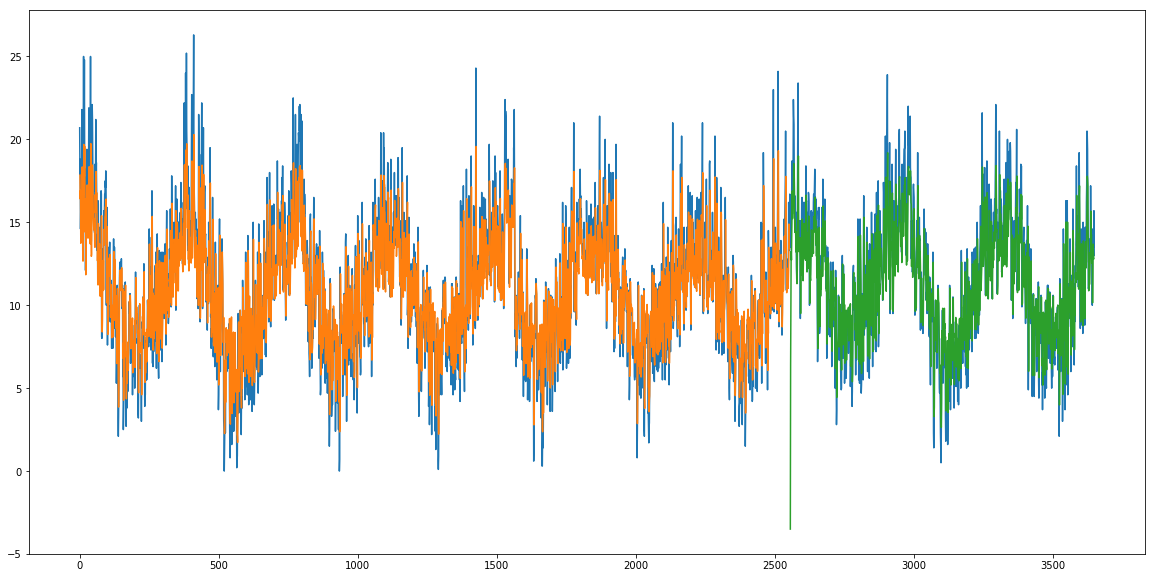

In [46]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()